In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [3]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [4]:
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

df_doc_wc

,Treatment,Campaign,Date,Location,NPOC Conc (mg/L),TN Conc (mg/L),Depth,Notes,Type,Time,Dil Factor,NPOC_uM,TN_uM,dil_fac,code
Sample ID,,,,,,,,,,,,,,,
211901,P2F,GOM2021,7/15/2021,St.MK,1.22200,0.1955,16.7,NaN,WC,NaN,NaN,101.833333,13.964286,NaN,St.MK_GOM2021
211902,P2F,GOM2021,7/15/2021,St.MK,1.22350,0.182,16.7,NaN,WC,NaN,NaN,101.958333,13.000000,NaN,St.MK_GOM2021
211903,P2F,GOM2021,7/15/2021,St.MK,1.35050,0.11485,14.0,NaN,WC,NaN,NaN,112.541667,8.203571,NaN,St.MK_GOM2021
211904,P2F,GOM2021,7/15/2021,St.MK,1.57650,BDL,14.0,NaN,WC,NaN,NaN,131.375000,0.323571,NaN,St.MK_GOM2021
211905,P2F,GOM2021,7/15/2021,St.MK,1.45250,0.1677,10.0,NaN,WC,NaN,NaN,121.041667,11.978571,NaN,St.MK_GOM2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225036,P2F,GOM22SU,7/21/2022,St.12,0.97345,0.066635,70.6,TN STD LOW,WC,NaN,NaN,81.120833,4.759643,NaN,St.12_GOM22SU
225037,P2F,GOM22SU,7/21/2022,St.12,1.04600,0.076015,45.0,TN STD LOW,WC,NaN,NaN,87.166667,5.429643,NaN,St.12_GOM22SU
225038,P2F,GOM22SU,7/21/2022,St.12,1.06300,0.07098,21.0,TN STD LOW,WC,NaN,NaN,88.583333,5.070000,NaN,St.12_GOM22SU


In [5]:
#DOC slopes pore water 
df_doc_wc = df_doc_wc.dropna(subset=["NPOC_uM"])
#df_doc_wc = df_doc_wc[df_doc_wc['NPOC_uM'] >= 1]

codes = df_doc_wc['code'].unique()

print(codes)
len(codes)

['St.MK_GOM2021' 'St.5B_GOM2021' 'St.4_GOM2021' 'St.14_GOM2021'
 'St.9_GOM2021' 'St.13_GOM2021' 'St.2_GOM2021' 'St.15_GOM2021'
 'St.16_GOM2021' 'St.11_GOM2021' 'St.7_GOM2021' 'St.ML_GOM2021'
 'St.5B_GOM21FA' 'St.6_GOM21FA' 'St.4_GOM21FA' 'St.MK_GOM21FA'
 'St.MK-2_GOM21FA' 'St.7_GOM21FA' 'St.14_GOM21FA' 'St.9_GOM21FA'
 'St.14.5_GOM21FA' 'St.15_GOM21FA' 'St.2_GOM21FA' 'St.16_GOM21FA'
 'St.12_GOM21FA' 'St.11_GOM21FA' 'St.13 _GOM21FA' 'St.16-2_GOM21FA'
 'St.7_GOM22SP' 'St.16_GOM22SP' 'St.5B_GOM22SP' 'St.15_GOM22SP'
 'St.14_GOM22SP' 'St.2_GOM22SP' 'St.13_GOM22SP' 'St.MK_GOM22SP'
 'St.4_GOM22SP' 'St.4_GOM22SU' 'St.5B_GOM22SU' 'St.13_GOM22SU'
 'St.2_GOM22SU' 'St.7_GOM22SU' 'St.15_GOM22SU' 'St.16_GOM22SU'
 'St.11_GOM22SU' 'St.MK_GOM22SU' 'St.9_GOM22SU' 'St.9_GOM22SP'
 'St.14_GOM22SU' 'St.12_GOM22SU']


50

for each code in codes: 
    ds = df_doc_wc[df_doc_wc['code'] == code]
    ds 

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_20768\3774575506.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))


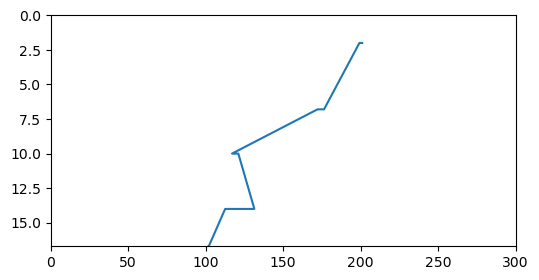

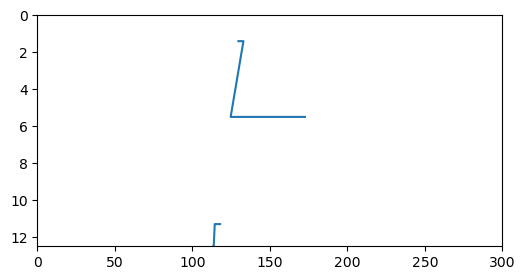

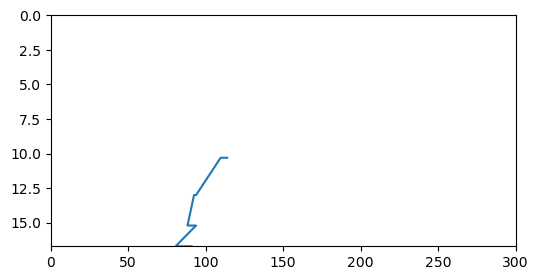

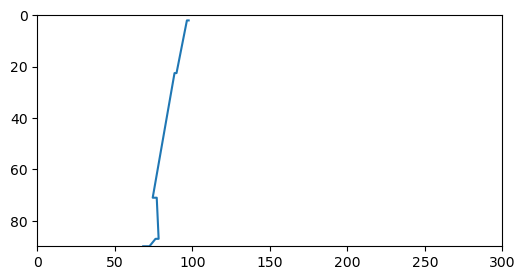

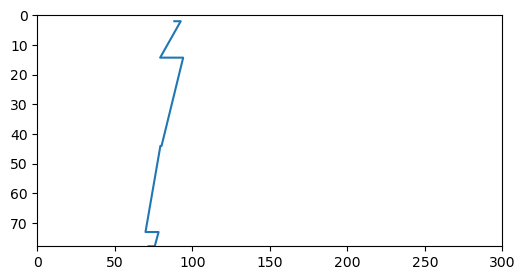

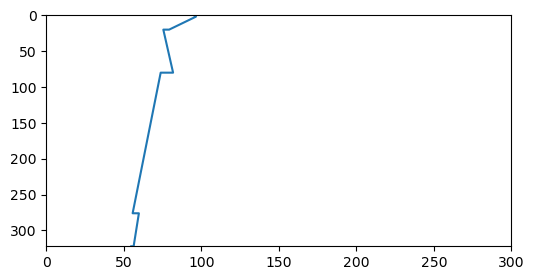

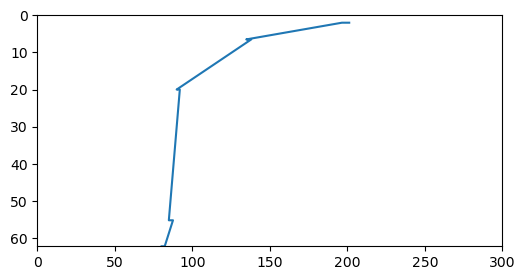

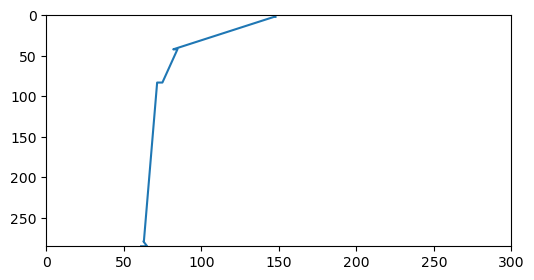

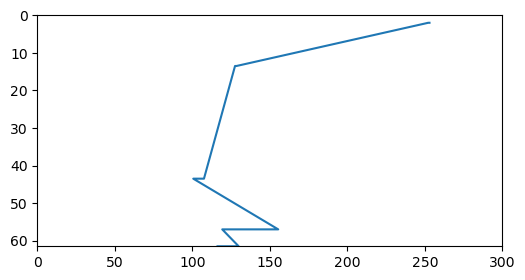

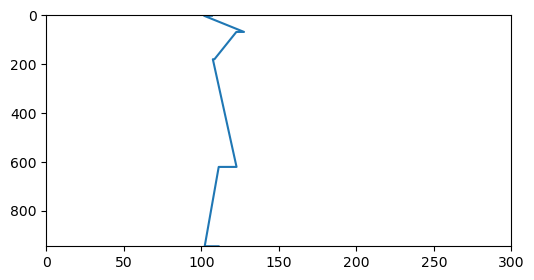

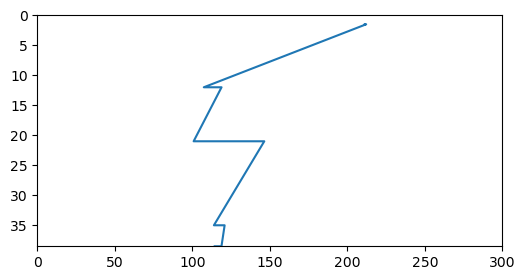

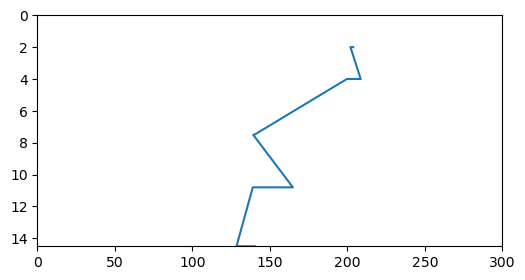

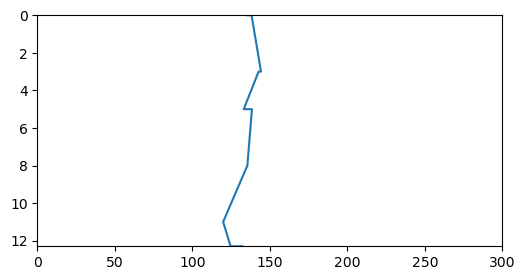

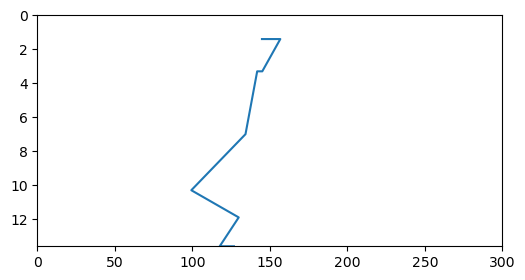

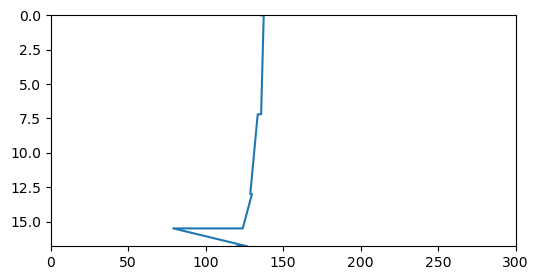

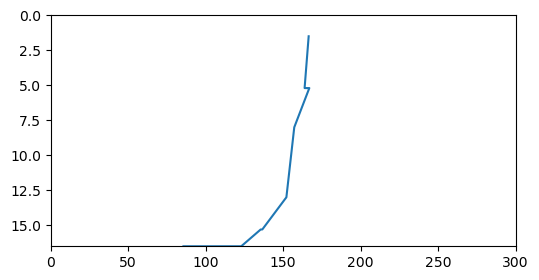

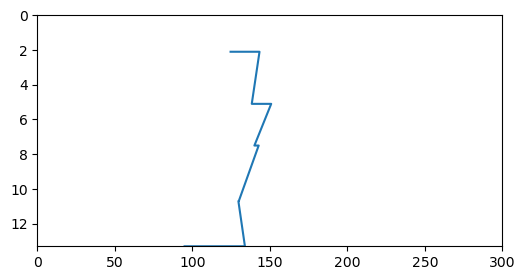

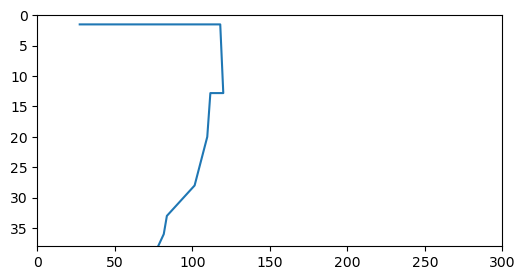

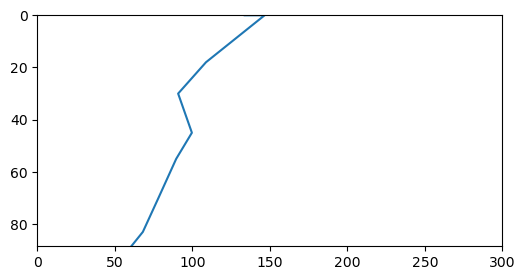

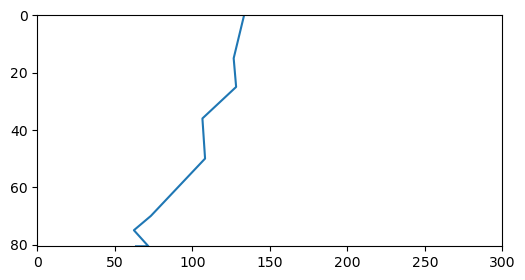

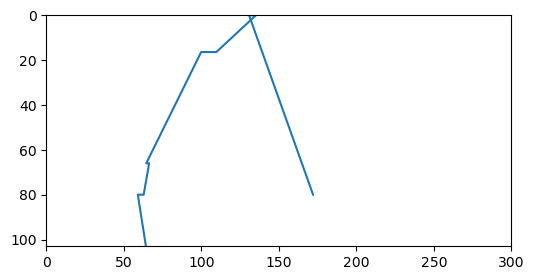

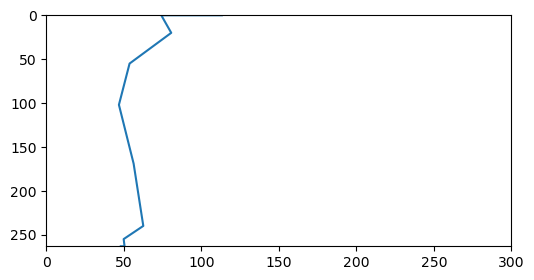

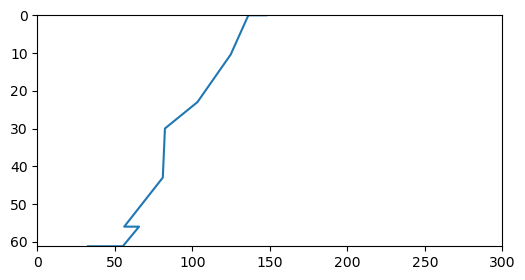

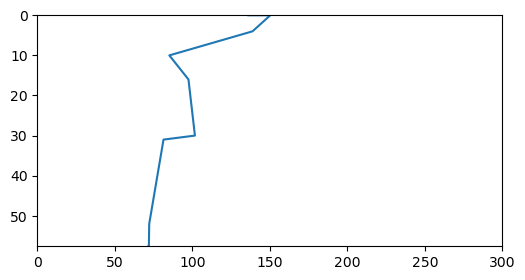

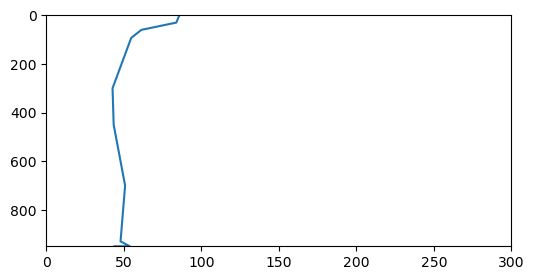

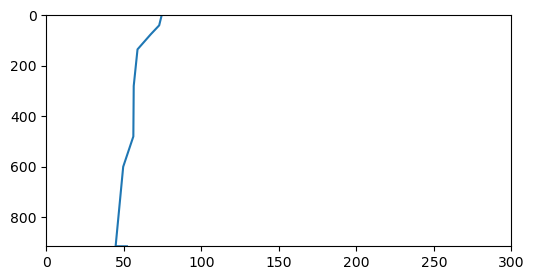

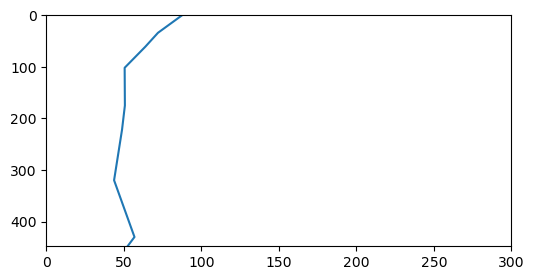

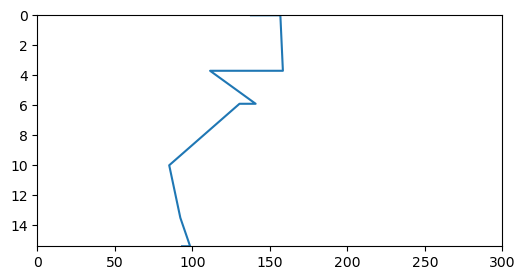

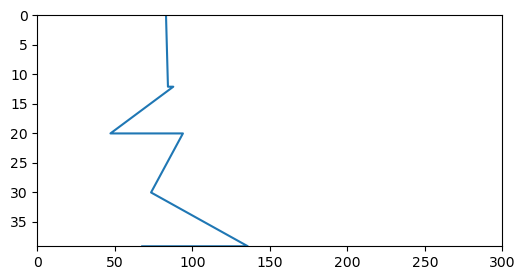

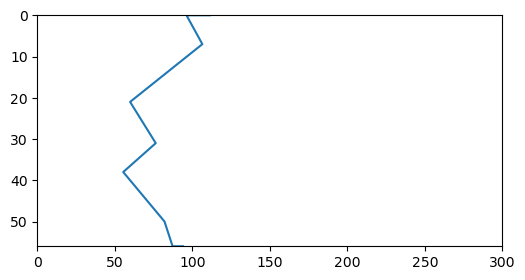

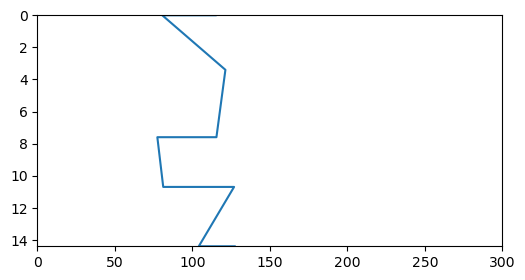

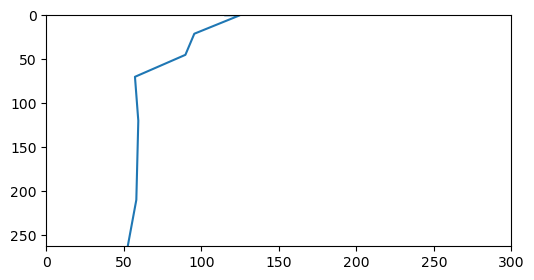

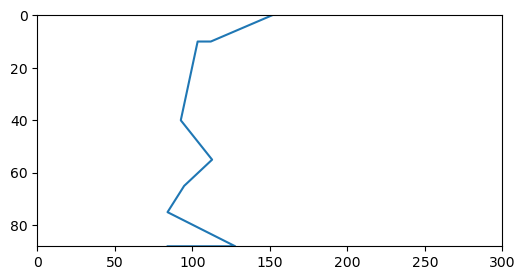

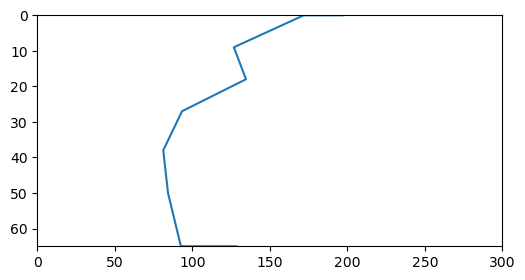

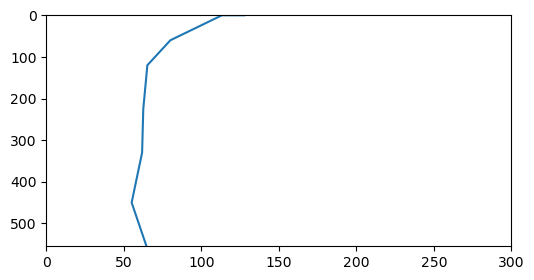

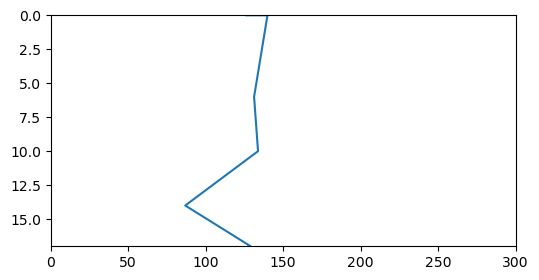

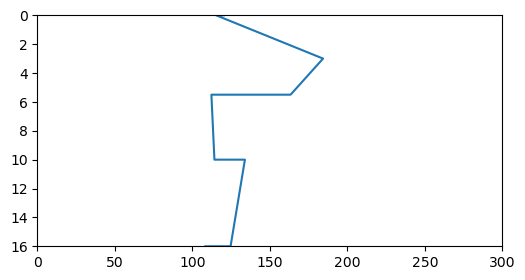

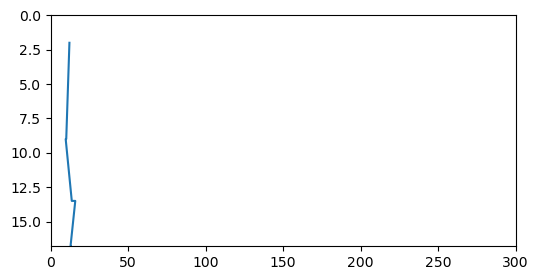

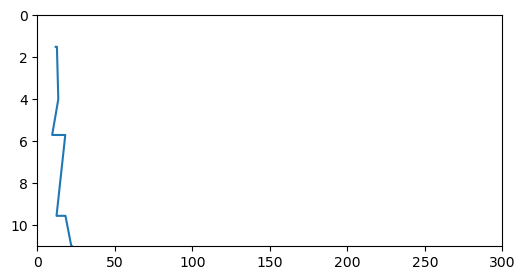

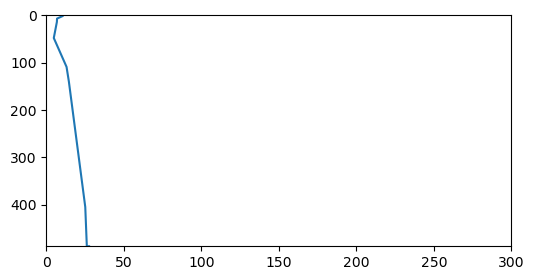

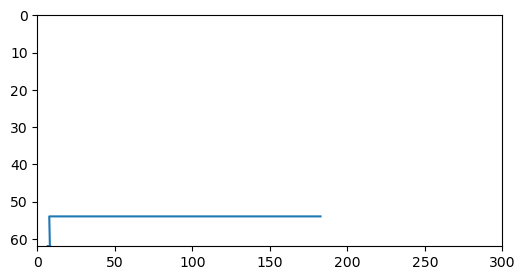

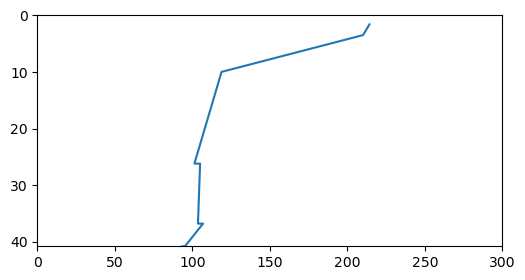

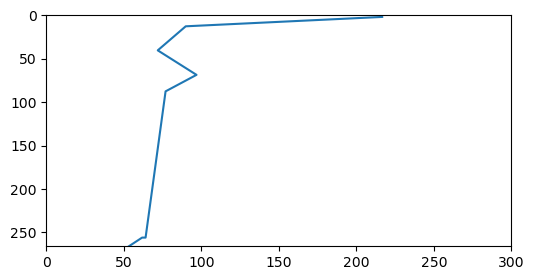

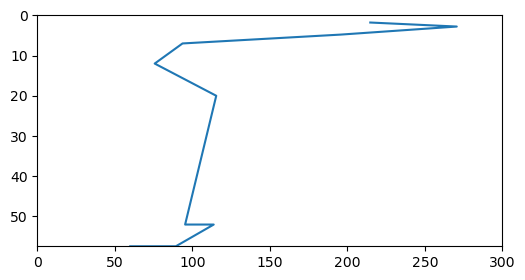

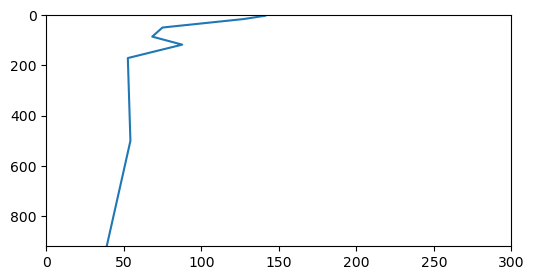

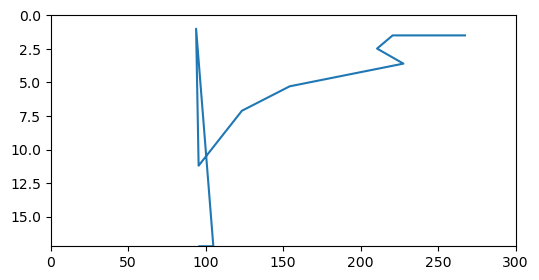

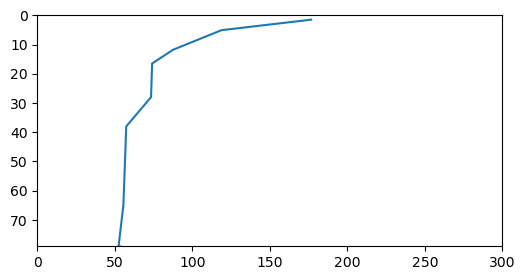

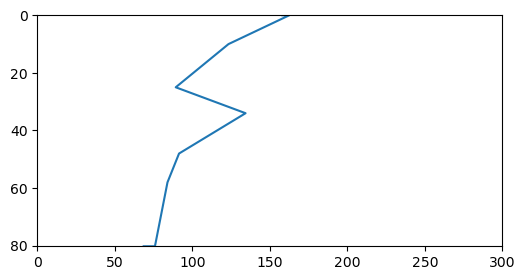

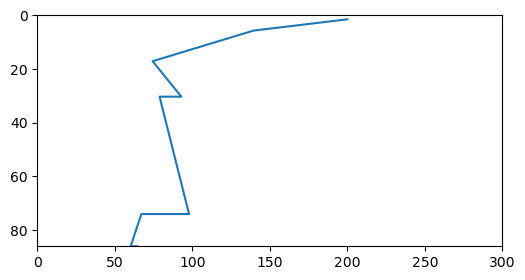

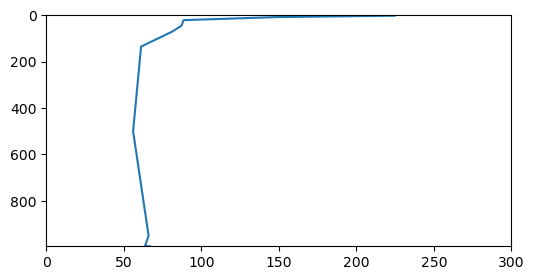

In [6]:
integrated_data = []

for code in codes:
    ds = df_doc_wc[df_doc_wc['code'] == code]
    depth = ds['Depth']
    npoc = ds['NPOC_uM']
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3)) 
    axs.plot(npoc,depth)
    axs.set_ylim(depth.max(),0)
    axs.set_xlim(0,300)

Shaded area for code St.MK_GOM2021: 859.3583339699999
Shaded area for code St.5B_GOM2021: nan
Shaded area for code St.4_GOM2021: nan
Shaded area for code St.14_GOM2021: 1373.8837505309998
Shaded area for code St.9_GOM2021: 769.6533750470002
Shaded area for code St.13_GOM2021: 4200.987916759999
Shaded area for code St.2_GOM2021: 1403.0083333265002
Shaded area for code St.15_GOM2021: 4272.2770825200005
Shaded area for code St.16_GOM2021: 1359.7083311250005
Shaded area for code St.11_GOM2021: 1049.5333623099941
Shaded area for code St.7_GOM2021: 819.6041674749995
Shaded area for code St.ML_GOM2021: 375.1500007750002
Shaded area for code St.5B_GOM21FA: 25.431250510000098
Shaded area for code St.6_GOM21FA: 54.88958314999995
Shaded area for code St.4_GOM21FA: 176.18374963450037
Shaded area for code St.MK_GOM21FA: 1161.004166915
Shaded area for code St.MK-2_GOM21FA: 549.0124997890001
Shaded area for code St.7_GOM21FA: 935.0687505749997
Shaded area for code St.14_GOM21FA: 3070.3385416749998
Sh

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_20768\1166360662.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 4))


Shaded area for code St.2_GOM21FA: 3705.501667134
Shaded area for code St.16_GOM21FA: 1169.123333257
Shaded area for code St.12_GOM21FA: 5645.568746800005
Shaded area for code St.11_GOM21FA: 2407.0312509000028
Shaded area for code St.13 _GOM21FA: 497.89489566400107
Shaded area for code St.16-2_GOM21FA: 356.43800598400003
Shaded area for code St.7_GOM22SP: 689.5813540763498
Shaded area for code St.16_GOM22SP: -913.1187499799998
Shaded area for code St.5B_GOM22SP: -319.4764585375
Shaded area for code St.15_GOM22SP: 3683.8879160349998
Shaded area for code St.14_GOM22SP: 1703.1270828300003
Shaded area for code St.2_GOM22SP: -1528.935414279999
Shaded area for code St.13_GOM22SP: 819.0937524750027
Shaded area for code St.MK_GOM22SP: -62.58333420500003
Shaded area for code St.4_GOM22SP: 434.93750037499996
Shaded area for code St.4_GOM22SU: -14.97552949775
Shaded area for code St.5B_GOM22SU: -86.04927243640003
Shaded area for code St.13_GOM22SU: -4797.896279931901
Shaded area for code St.2_GOM

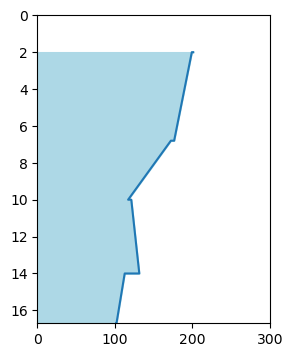

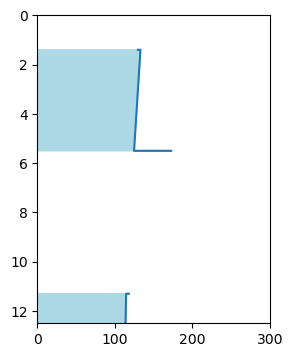

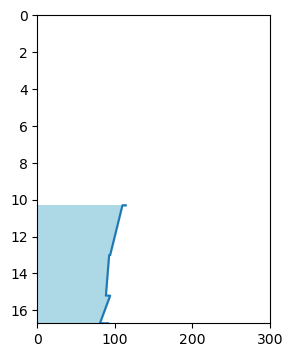

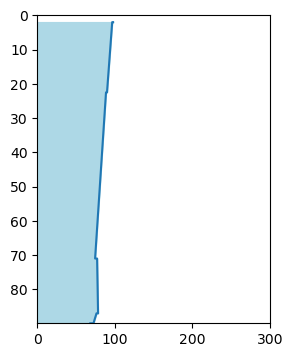

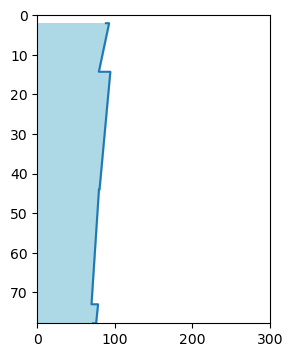

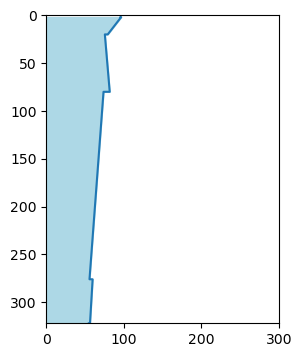

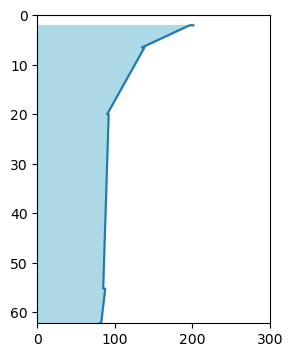

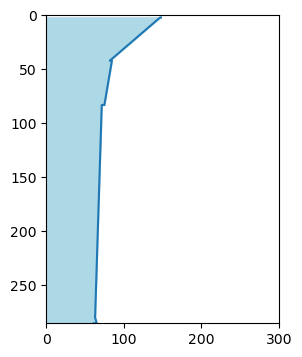

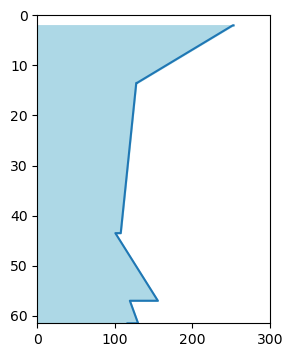

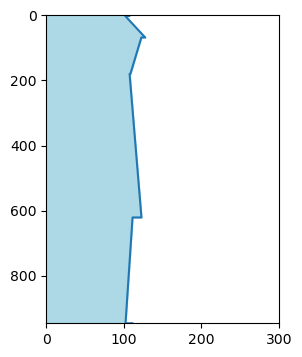

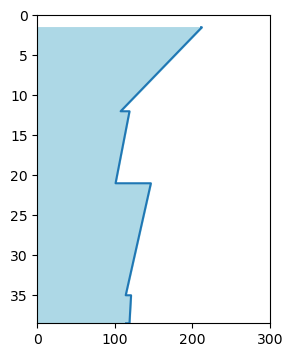

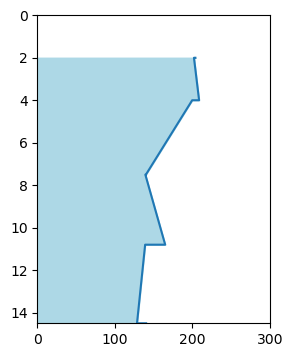

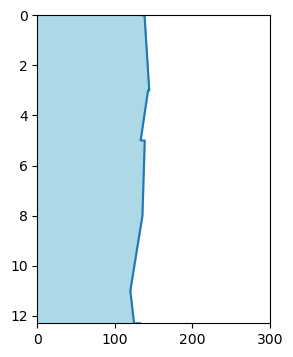

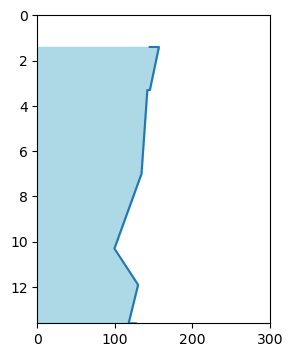

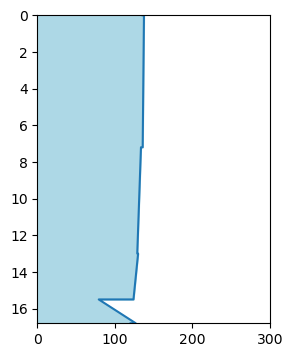

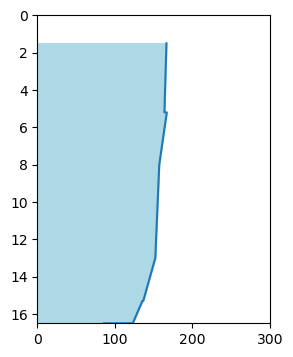

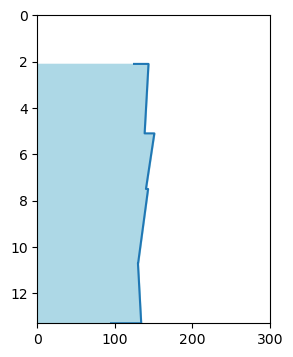

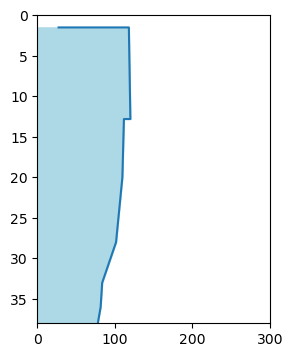

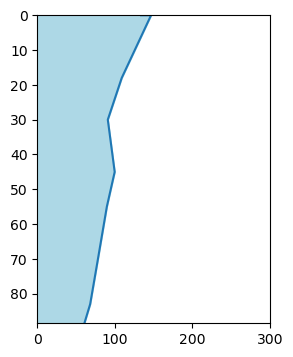

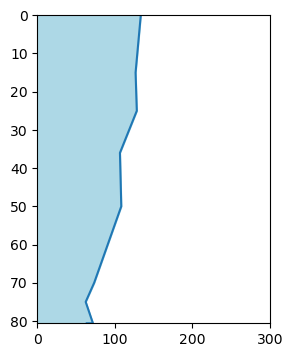

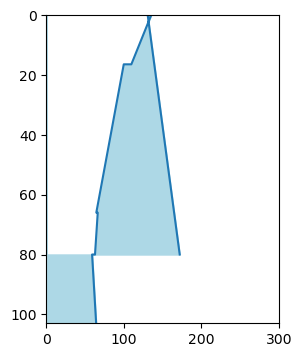

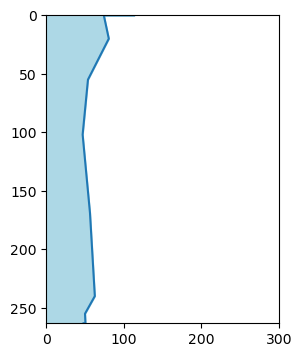

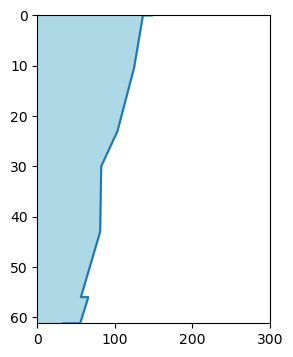

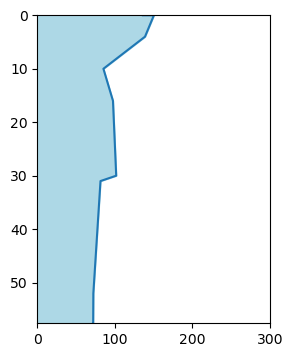

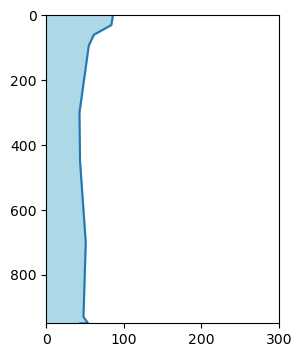

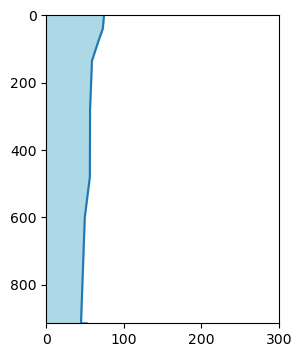

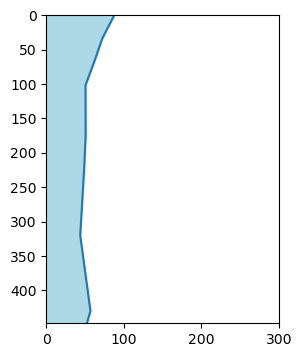

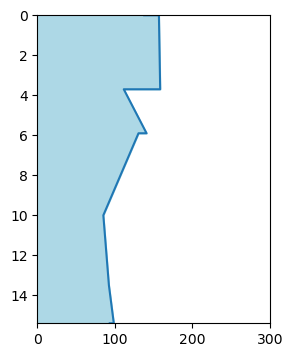

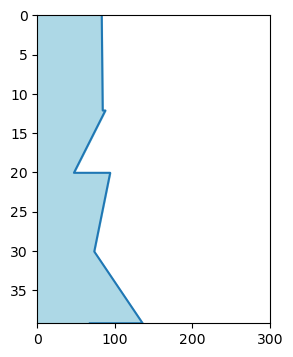

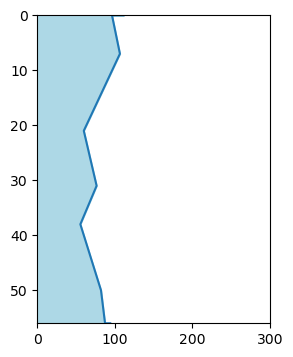

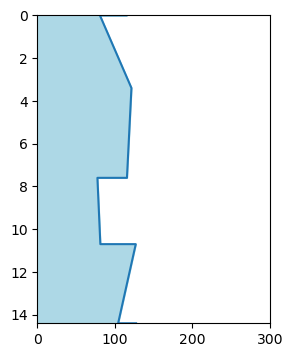

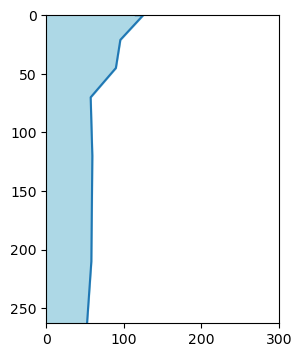

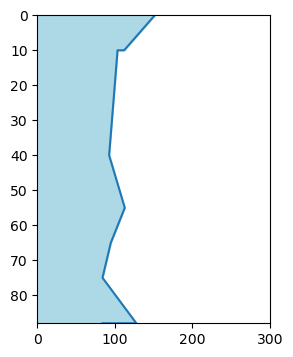

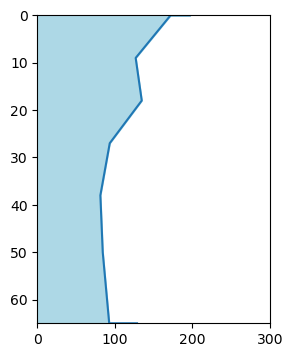

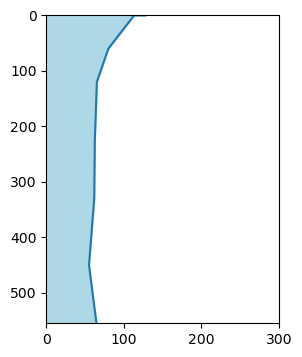

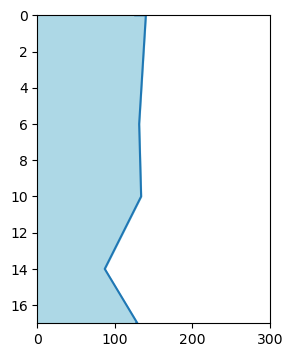

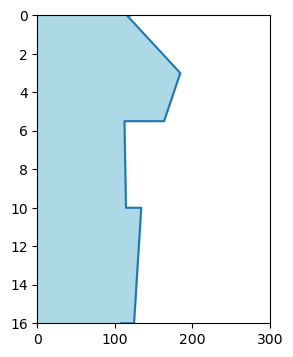

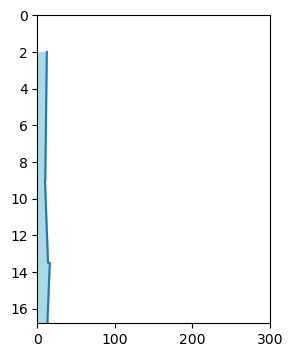

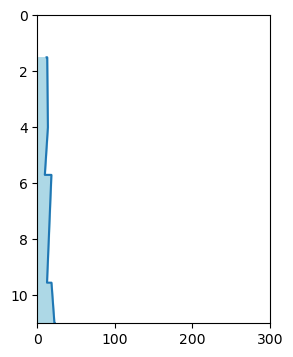

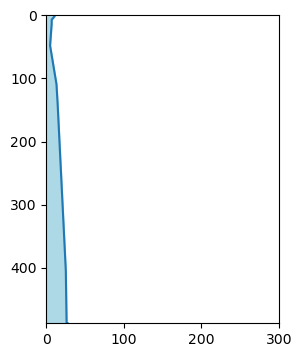

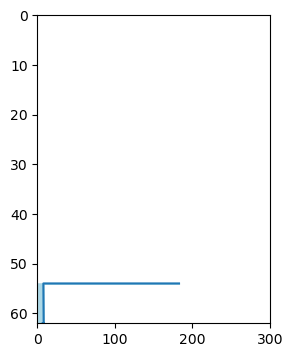

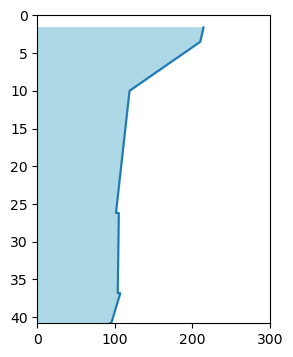

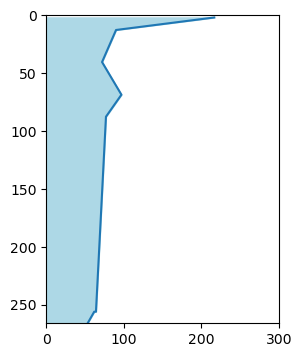

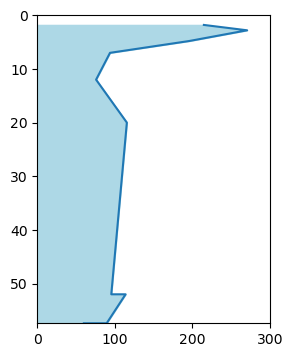

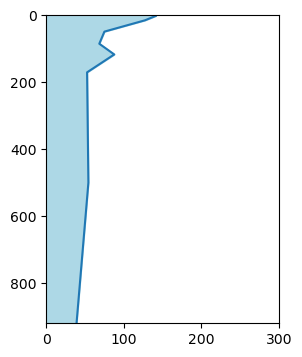

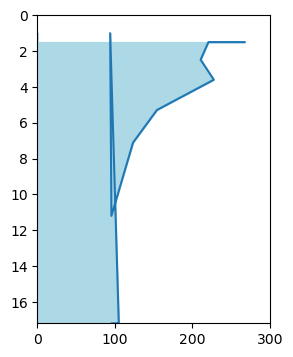

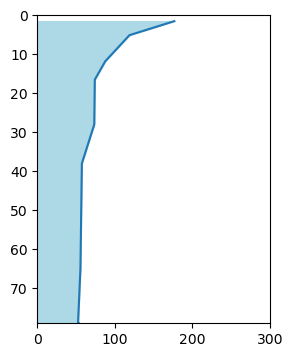

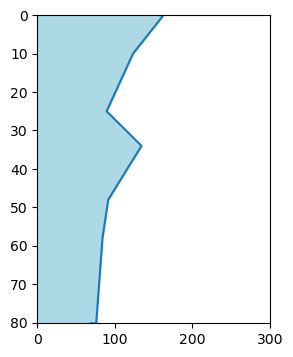

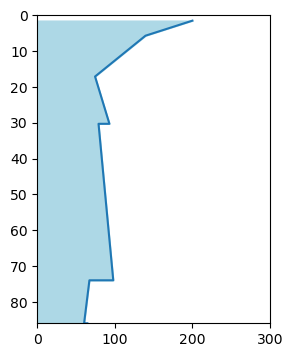

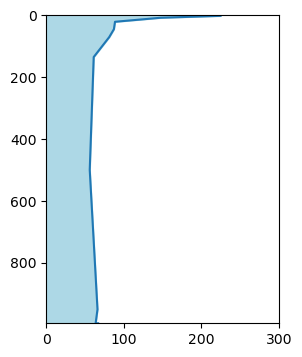

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have df_doc_wc DataFrame and 'codes' list defined

integrated_data = []

for code in codes:
    ds = df_doc_wc[df_doc_wc['code'] == code]
    depth = ds['Depth']
    npoc = ds['NPOC_uM']
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 4)) 
    axs.plot(npoc, depth)
    axs.set_ylim(depth.max(), 0)
    axs.set_xlim(0, 300)
    
    # Shade the area to the left of the data points
    axs.fill_betweenx(depth, npoc, color='lightblue')
    
    # Calculate the shaded area
    shaded_area = np.trapz(depth, npoc)
    integrated_data.append(shaded_area)
    print(f"Shaded area for code {code}: {shaded_area}")

plt.show()


Shaded area for code St.MK_GOM2021: 2151536.4583575
Shaded area for code St.5B_GOM2021: 1479217.7081825
Shaded area for code St.4_GOM2021: 611638.020828
Shaded area for code St.14_GOM2021: 7337137.7085065
Shaded area for code St.9_GOM2021: 6138082.93748545
Shaded area for code St.13_GOM2021: 22102252.500412
Shaded area for code St.2_GOM2021: 5985546.875078499
Shaded area for code St.15_GOM2021: 21518480.20733
Shaded area for code St.16_GOM2021: 7879812.5001375
Shaded area for code St.11_GOM2021: 106537456.23778501
Shaded area for code St.7_GOM2021: 4863927.0831
Shaded area for code St.ML_GOM2021: 2018451.0419425
Shaded area for code St.5B_GOM21FA: 1650301.041775
Shaded area for code St.6_GOM21FA: 1575679.1665275
Shaded area for code St.4_GOM21FA: 2176281.458451
Shaded area for code St.MK_GOM21FA: 2313402.0834975
Shaded area for code St.MK-2_GOM21FA: 1511777.0832405002
Shaded area for code St.7_GOM21FA: 3587349.27135275
Shaded area for code St.14_GOM21FA: 8368682.29108
Shaded area for c

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_20768\355000680.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))


Shaded area for code St.16_GOM21FA: 5280704.166465
Shaded area for code St.12_GOM21FA: 47280818.75
Shaded area for code St.11_GOM21FA: 50550140.6256375
Shaded area for code St.13 _GOM21FA: 23969260.024624
Shaded area for code St.16-2_GOM21FA: 1760033.2652892503
Shaded area for code St.7_GOM22SP: 3161673.3124892507
Shaded area for code St.16_GOM22SP: 4380091.6666175
Shaded area for code St.5B_GOM22SP: 1546250.9373715003
Shaded area for code St.15_GOM22SP: 17434954.166035
Shaded area for code St.14_GOM22SP: 8995981.249605
Shaded area for code St.2_GOM22SP: 7011606.2499325005
Shaded area for code St.13_GOM22SP: 36891093.749625
Shaded area for code St.MK_GOM22SP: 2086281.2498449998
Shaded area for code St.4_GOM22SP: 2165874.9998749997
Shaded area for code St.4_GOM22SU: 177294.490584125
Shaded area for code St.5B_GOM22SU: 137563.9428855125
Shaded area for code St.13_GOM22SU: 8669681.6677976
Shaded area for code St.2_GOM22SU: 411778.8457873485
Shaded area for code St.7_GOM22SU: 4771379.16700

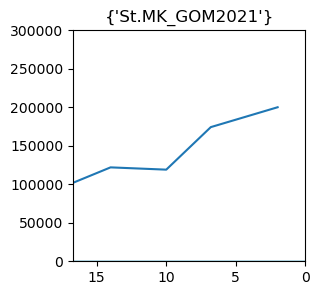

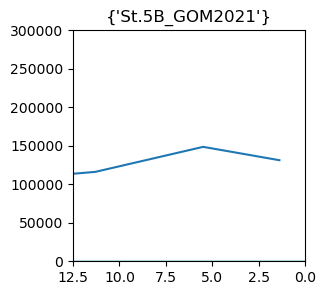

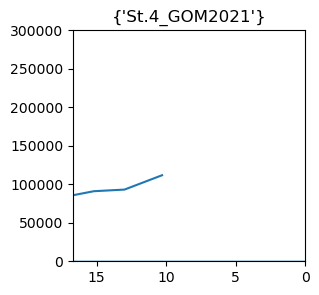

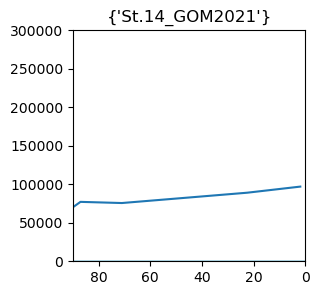

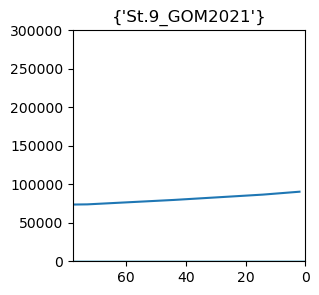

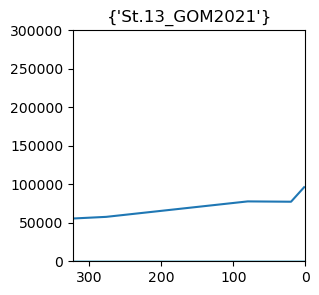

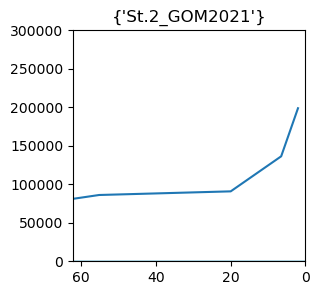

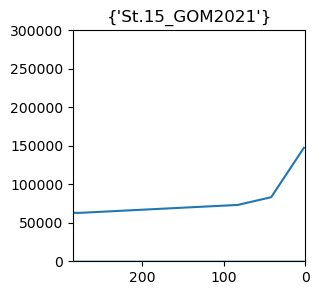

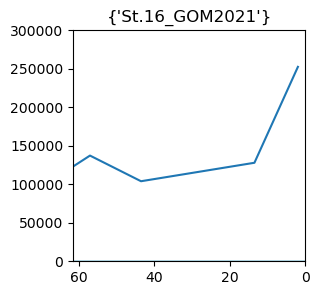

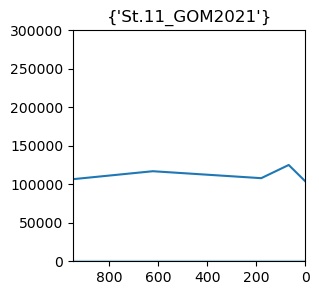

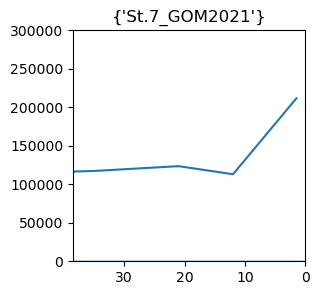

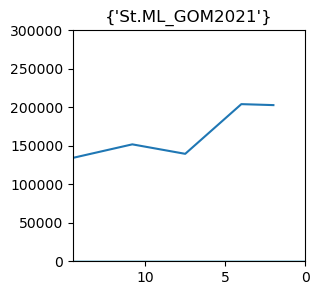

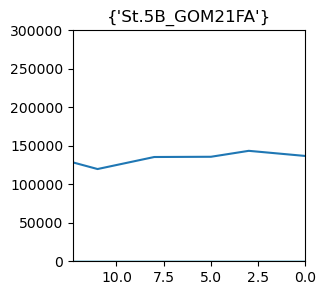

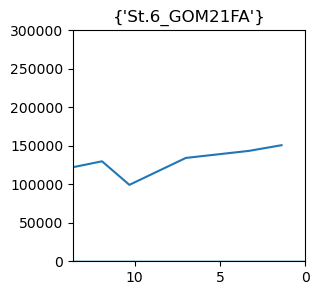

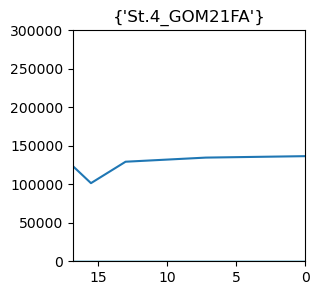

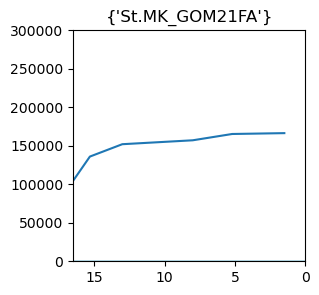

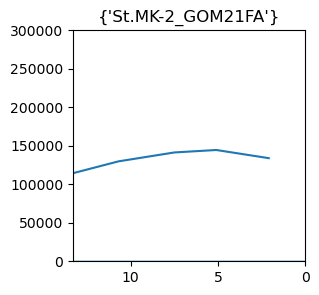

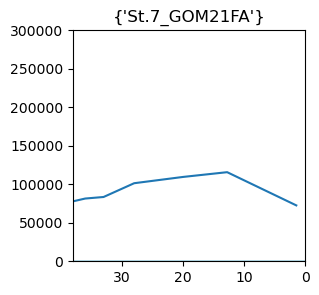

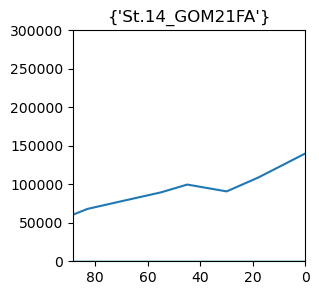

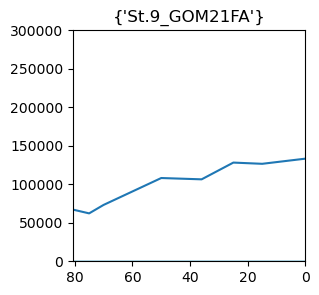

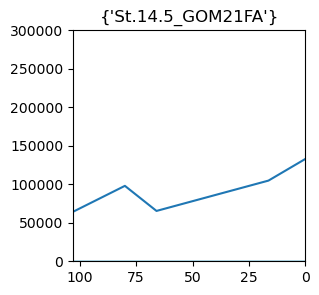

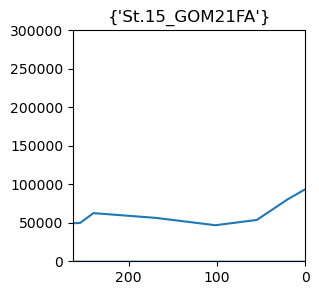

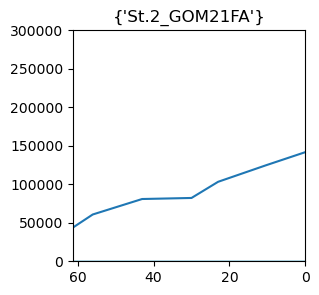

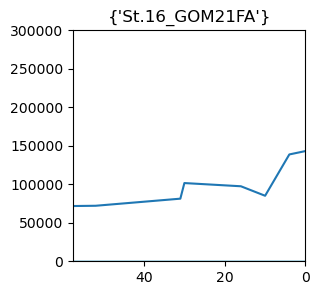

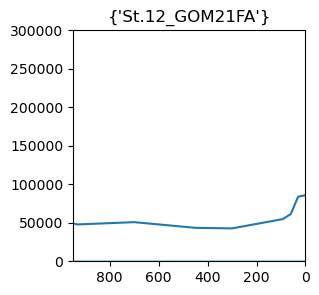

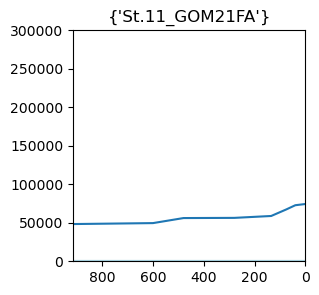

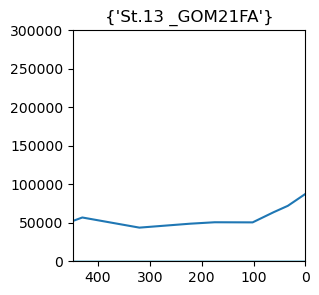

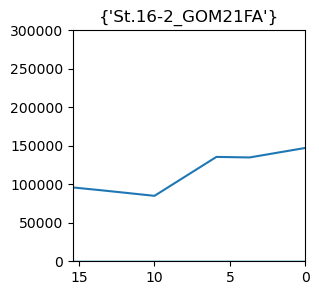

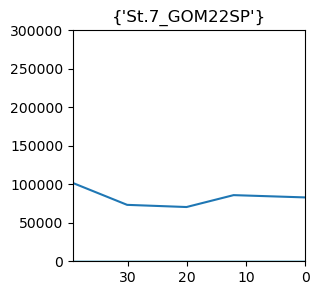

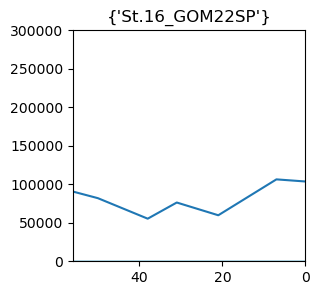

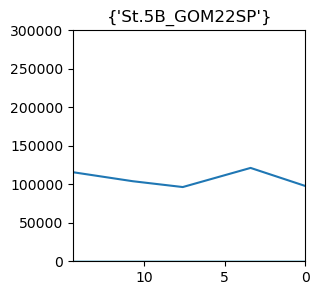

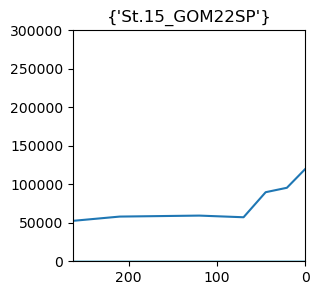

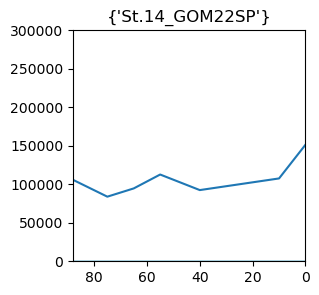

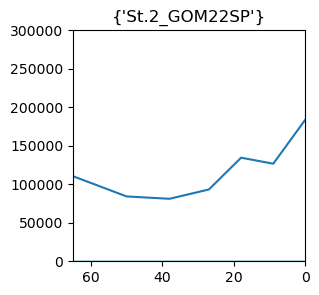

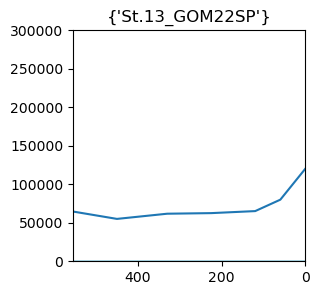

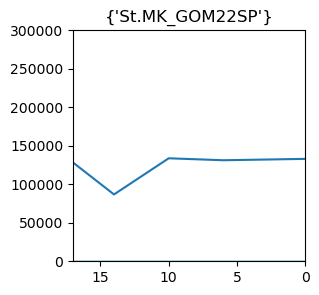

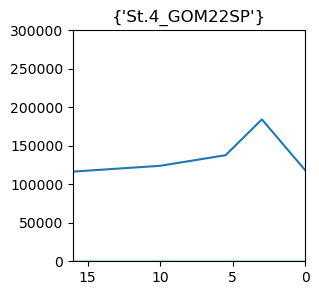

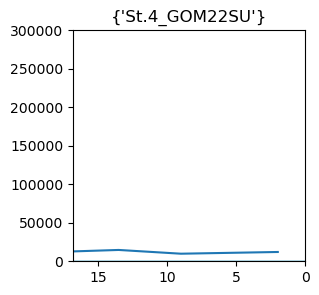

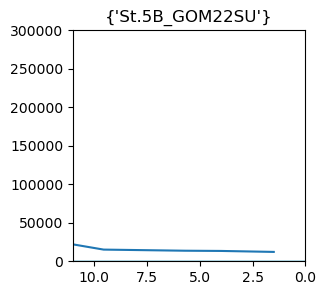

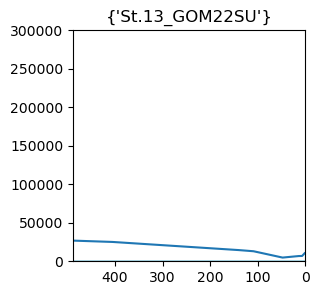

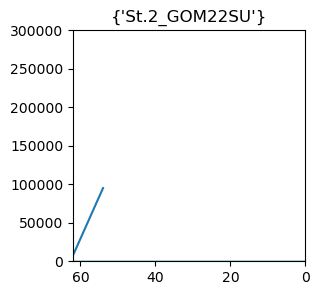

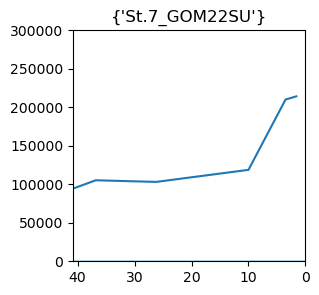

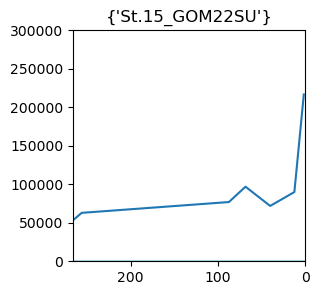

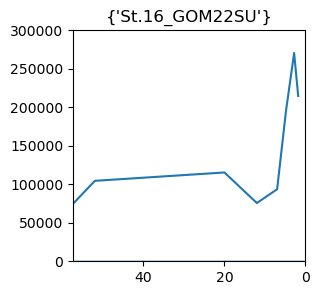

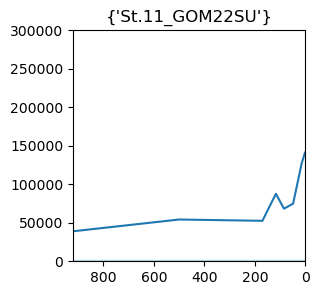

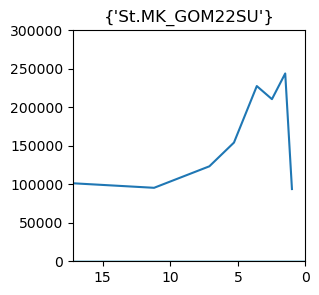

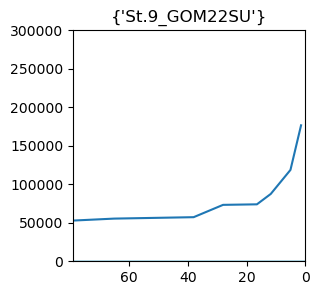

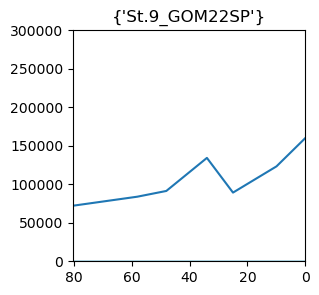

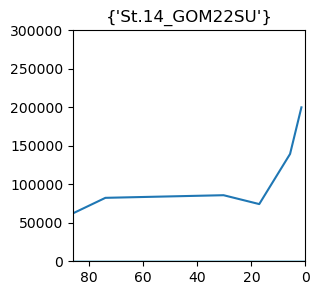

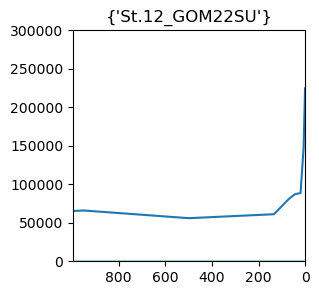

In [8]:

integrated_data = []

for code in codes:
    ds = df_doc_wc[df_doc_wc['code'] == code]
    # Take the average of NPOC_uM values at the same depth
    ds_avg = ds.groupby('Depth')['NPOC_uM'].mean().reset_index()
    
    depth = ds_avg['Depth']
    npoc = ds_avg['NPOC_uM']
    
    npoc = ds_avg['NPOC_uM']*1000
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3)) 
    axs.plot(depth, npoc)
    axs.set_xlim(depth.max(), 0)
    axs.set_ylim(0, 300000)
    axs.set_title({code})
    
    # Shade the area to the left of the data points
    axs.fill_betweenx(depth, npoc, color='lightblue')
    
    # Calculate the shaded area
    shaded_area = np.trapz(npoc, depth)
    integrated_data.append(shaded_area)
    print(f"Shaded area for code {code}: {shaded_area}")

plt.show()


In [9]:
integrated_data

[2151536.4583575,
 1479217.7081825,
 611638.020828,
 7337137.7085065,
 6138082.93748545,
 22102252.500412,
 5985546.875078499,
 21518480.20733,
 7879812.5001375,
 106537456.23778501,
 4863927.0831,
 2018451.0419425,
 1650301.041775,
 1575679.1665275,
 2176281.458451,
 2313402.0834975,
 1511777.0832405002,
 3587349.27135275,
 8368682.29108,
 8528311.945009,
 9178316.8059,
 15378071.0413585,
 5722858.958581501,
 5280704.166465,
 47280818.75,
 50550140.6256375,
 23969260.024624,
 1760033.2652892503,
 3161673.3124892507,
 4380091.6666175,
 1546250.9373715003,
 17434954.166035,
 8995981.249605,
 7011606.2499325005,
 36891093.749625,
 2086281.2498449998,
 2165874.9998749997,
 177294.490584125,
 137563.9428855125,
 8669681.6677976,
 411778.8457873485,
 4771379.167005001,
 20280835.833116498,
 6214207.290647,
 51179732.082879,
 2165134.04171718,
 5379839.166614,
 8203511.6665940005,
 7530081.770767501,
 63352831.87608349]

In [10]:
mean_values = df_doc_wc.groupby('code')['NPOC_uM'].mean()
max_values = df_doc_wc.groupby('code')['Depth'].max()

result_df = pd.concat([mean_values, max_values], axis=1, keys=['mean_NPOC_uM', 'max_depth'])

result_df.index.name = 'code'

result_df['NPOC_uM_per_cubic_meter'] = result_df['mean_NPOC_uM'] * 1000
result_df['NPOC_uMol_Stock_wc'] = result_df['NPOC_uM_per_cubic_meter'] * result_df['max_depth']

result_df['NPOC_uMol_Stock_wc'] = integrated_data
result_df['NPOC_uM_per_cubic_meter'] = result_df['NPOC_uMol_Stock_wc'] / result_df['max_depth']
result_df['mean_NPOC_uM'] = result_df['NPOC_uM_per_cubic_meter'] / 1000

result_df.to_csv('../Dissertation_projects/Data/Stats_data_sets/Water_col_DOC_stocks.csv')

result_df

,mean_NPOC_uM,max_depth,NPOC_uM_per_cubic_meter,NPOC_uMol_Stock_wc
code,,,,
St.11_GOM2021,2.274351,946.0,2.274351e+03,2.151536e+06
St.11_GOM21FA,1.616631,915.0,1.616631e+03,1.479218e+06
St.11_GOM22SU,0.664824,920.0,6.648239e+02,6.116380e+05
St.12_GOM21FA,7.723303,950.0,7.723303e+03,7.337138e+06
St.12_GOM22SU,6.162734,996.0,6.162734e+03,6.138083e+06
St.13 _GOM21FA,49.335385,448.0,4.933539e+04,2.210225e+07
St.13_GOM2021,18.588655,322.0,1.858865e+04,5.985547e+06
St.13_GOM22SP,38.772036,555.0,3.877204e+04,2.151848e+07
St.13_GOM22SU,16.147157,488.0,1.614716e+04,7.879813e+06


result_df = pd.concat([mean_values, max_values], axis=1, keys=['mean_NPOC_uM', 'max_depth'])

result_df.index.name = 'code'

result_df['NPOC_uM_per_cubic_meter'] = result_df['mean_NPOC_uM'] * 1000
result_df['NPOC_uMol_Stock_wc'] = result_df['NPOC_uM_per_cubic_meter'] * result_df['max_depth']

result_df.to_csv('../Dissertation_projects/Data/Stats_data_sets/Water_col_DOC_stocks.csv')

result_df